# **Loading the dataset**

In [ ]:
# We first import the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.multivariate.pca import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.inspection import permutation_importance
import time
from sklearn.tree import export_text

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reading the data csv file
orig_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/healthcare_dataset_stroke_data_synthetic.csv") # the name of the index column is specified here
orig_data.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,26.000000,0,0,No,Govt_job,Urban,59.670000,24.500000,smokes,0
1,Female,34.000000,0,0,No,Govt_job,Urban,60.360000,24.100000,never smoked,0
2,Female,2.000000,0,0,No,children,Urban,125.030000,19.800000,Unknown,0
3,Female,74.935160,0,0,Yes,Private,Rural,64.166503,28.993051,never smoked,1
4,Female,24.000000,0,0,No,Private,Urban,65.440000,23.600000,never smoked,0
5,Male,77.786949,1,1,No,Self-employed,Rural,220.422194,39.542119,smokes,1
6,Male,47.000000,1,0,Yes,Private,Urban,110.250000,44.300000,never smoked,0
7,Female,66.712679,0,0,Yes,Self-employed,Rural,56.110000,21.620396,formerly smoked,1
8,Female,39.000000,0,0,Yes,Private,Urban,87.390000,57.900000,never smoked,0
9,Female,63.810022,1,0,Yes,Private,Urban,56.110000,28.026607,smokes,1


In [ ]:
orig_data.shape

(8909, 11)

In [ ]:
# there is only 1 entry where the gender is "other"
# Since it is hence not significant, we are dropping that row
orig_data.drop(orig_data[orig_data['gender'] == "Other"].index, inplace=True) # Dropping the Other value

# **Data Exploration**

In [ ]:
# We first get a preliminary sense of the dataset
orig_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8908 entries, 0 to 8908
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             8908 non-null   object 
 1   age                8908 non-null   float64
 2   hypertension       8908 non-null   int64  
 3   heart_disease      8908 non-null   int64  
 4   ever_married       8908 non-null   object 
 5   work_type          8908 non-null   object 
 6   Residence_type     8908 non-null   object 
 7   avg_glucose_level  8908 non-null   float64
 8   bmi                8908 non-null   float64
 9   smoking_status     8908 non-null   object 
 10  stroke             8908 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 835.1+ KB


In [ ]:
orig_data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000
mean,53.698054,0.211832,0.147059,119.091578,29.623095,0.472497
std,21.935528,0.408629,0.354184,56.441147,7.232871,0.499271
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,40.000000,0.000000,0.000000,78.304613,24.700000,0.000000
50%,58.201451,0.000000,0.000000,98.050000,29.104568,0.000000
75%,71.000000,0.000000,0.000000,146.595000,34.003551,1.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


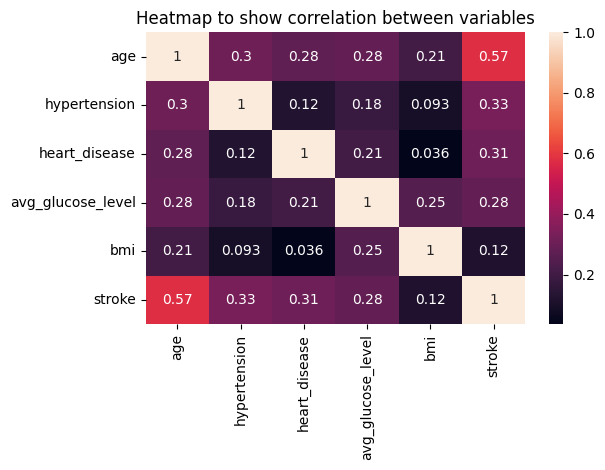

In [ ]:
# We will start of by looking at the correlation between the various variables here
# (those which have numeric values, we will create a more detailed heatmap with all variables further into the notebook).
num_data = orig_data[["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "stroke"]]
sns.heatmap(num_data.corr(), annot=True, fmt=".2g")
plt.title("Heatmap to show correlation between variables")
plt.tight_layout()

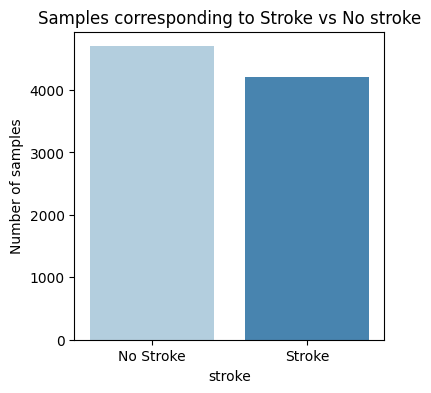

In [ ]:
import seaborn as sns

# Plotting the number of samples which correspond to a stroke vs those which don't
fig = plt.figure(figsize=(4, 4))
sns.countplot(x="stroke", data=orig_data, palette="Blues")
plt.xticks(ticks=[0, 1], labels=["No Stroke", "Stroke"])
plt.ylabel("Number of samples")
plt.title("Samples corresponding to Stroke vs No stroke")
plt.show()

The dataset is clearly very imbalanced, with a significanlty larger number of cases corresponding to 'no stroke'. This is something we will need to take into consideration while creating our classification model.

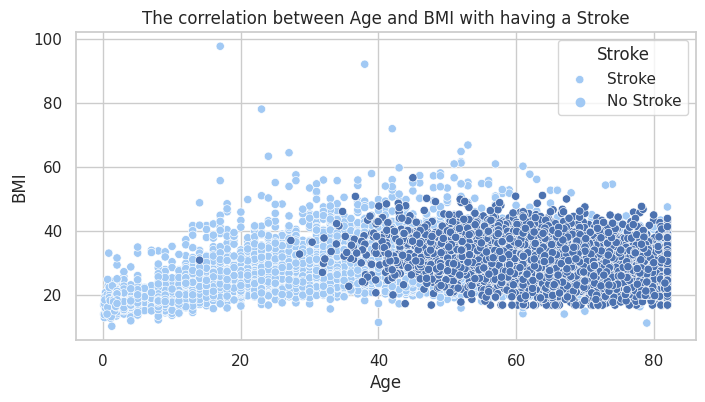

In [ ]:

# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create two separate scatter plots, first for 'stroke' and then for 'no stroke'
plt.figure(figsize=(8, 4))

# Plot the 'no stroke' data points (appearing below 'stroke')
sns.scatterplot(x="age", y="bmi", hue="stroke", data=orig_data[orig_data['stroke'] == 0], palette="pastel6")

# Plot the 'stroke' data points (appearing above 'no stroke')
sns.scatterplot(x="age", y="bmi", hue="stroke", data=orig_data[orig_data['stroke'] == 1])



# Set axis labels and title
plt.xlabel("Age")
plt.ylabel("BMI")
plt.title("The correlation between Age and BMI with having a Stroke")

# Show the legend with labels for 'No Stroke' and 'Stroke'
plt.legend(title="Stroke", labels=["Stroke", "No Stroke"])

# Display the plot
plt.show()

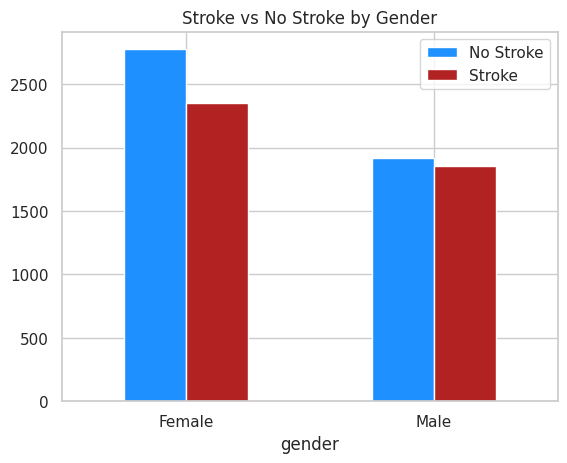

In [ ]:
# Let's visualize the gender crosstab, i.e. the distribution across gender categories
pd.crosstab(orig_data.gender, orig_data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Gender")
plt.show()

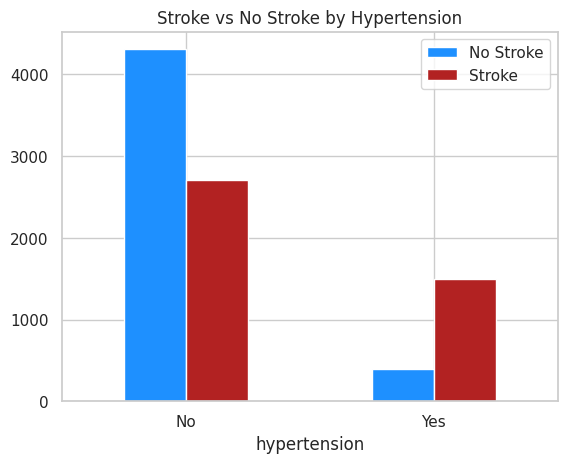

In [ ]:
# Let's visualize the distribution across hypertension categories
pd.crosstab(orig_data.hypertension, orig_data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Hypertension")
plt.xticks(ticks=[1,0], labels=["Yes", "No"])
plt.show()

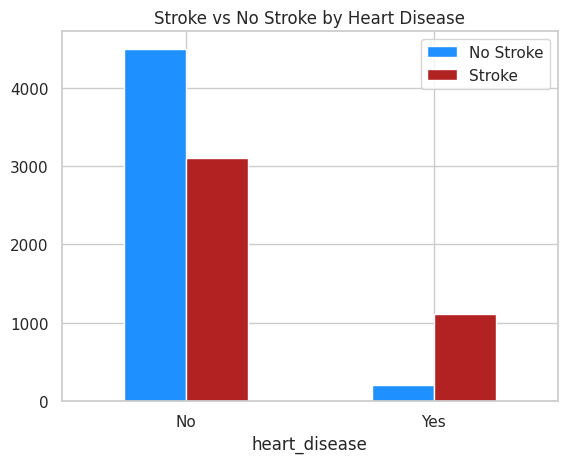

In [ ]:
# Let's visualize the distribution across heart disease categories
pd.crosstab(orig_data.heart_disease, orig_data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Heart Disease")
plt.xticks(ticks=[1,0], labels=["Yes", "No"])
plt.show()

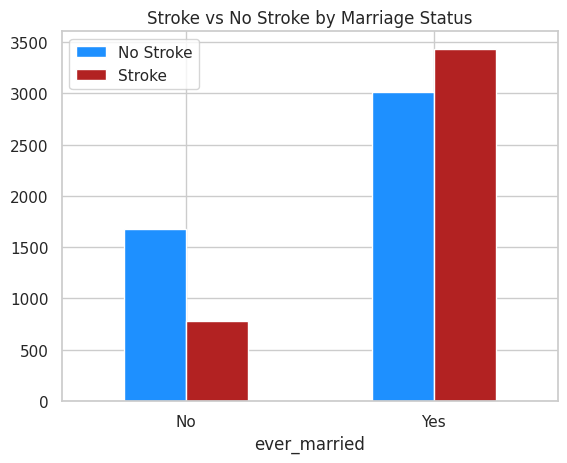

In [ ]:
# Let's visualize the distribution across marriage status
pd.crosstab(orig_data.ever_married, orig_data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Marriage Status")
plt.show()

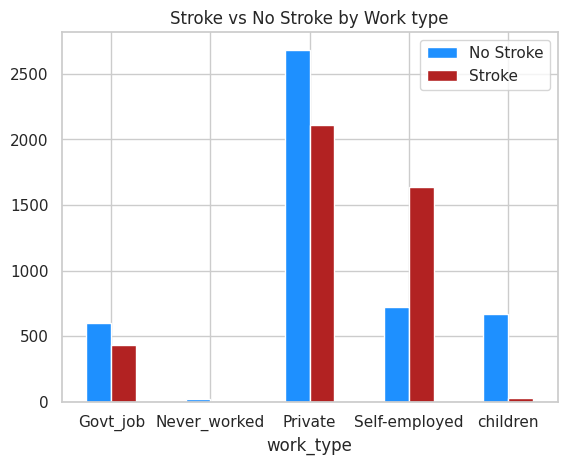

In [ ]:
# Let's visualize the distribution across work types
pd.crosstab(orig_data.work_type, orig_data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Work type")
plt.show()

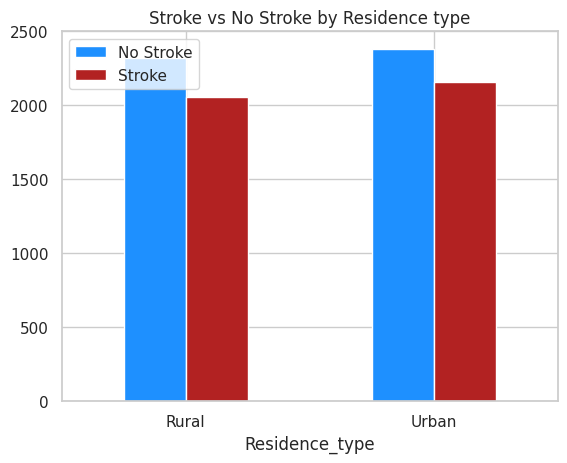

In [ ]:
# Let's visualize the distribution across Residence type
pd.crosstab(orig_data.Residence_type, orig_data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Residence type")
plt.show()

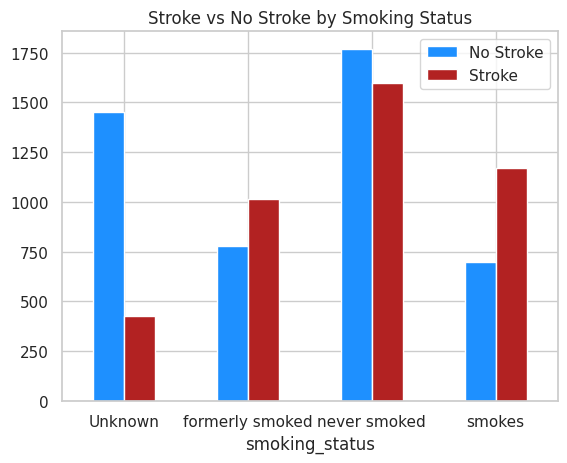

In [ ]:
# Let's visualize the distribution across smoking status
pd.crosstab(orig_data.smoking_status, orig_data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Smoking Status")
plt.show()

# **Data Pre-processing**

In [ ]:
# Before splitting the data into X and Y, we will perform some pre-processing on the data.
data = orig_data.values
data

array([['Female', 26.0, 0, ..., 24.5, 'smokes', 0],
       ['Female', 34.0, 0, ..., 24.1, 'never smoked', 0],
       ['Female', 2.0, 0, ..., 19.8, 'Unknown', 0],
       ...,
       ['Female', 75.21567256379822, 0, ..., 34.080727407255544,
        'smokes', 1],
       ['Female', 82.0, 1, ..., 27.36117278674833, 'formerly smoked', 1],
       ['Male', 51.0, 0, ..., 35.2, 'smokes', 0]], dtype=object)

In [ ]:
print("A sample entry:")
data[0]

A sample entry:


array(['Female', 26.0, 0, 0, 'No', 'Govt_job', 'Urban', 59.67, 24.5,
       'smokes', 0], dtype=object)

As can be seen, gender, ever_married, work_type, Residence_type and smoking_status are currently strings. We require numerical represenations of these.


For gender, ever_married and Residence_type, we can simply convert the values to binary labels, since all 3 only take 2 values:

**gender:** Female, Male

**ever_married:** Yes, No

**Residence_type:** Urban, Rural

In [ ]:
labelencoder = LabelEncoder()
data[:,0] = labelencoder.fit_transform(data[:,0]) # gender
data[:,4] = labelencoder.fit_transform(data[:,4]) # ever_married
data[:,6] = labelencoder.fit_transform(data[:,6]) # Residence_type

In [ ]:
print("Modified entry:")
data[0]

Modified entry:


array([0, 26.0, 0, 0, 0, 'Govt_job', 1, 59.67, 24.5, 'smokes', 0],
      dtype=object)

For work_type and smoking_status, we will need to create one hot encodings, since they can take 3 different values. We

In [ ]:
# First, we are creating numerical labels
# However, this is not enough, since it ends up giving importance to some labels over others
data[:,5] = labelencoder.fit_transform(data[:,5]) # work_type
data[:,9] = labelencoder.fit_transform(data[:,9]) # smoking_status

In [ ]:
data[0]

array([0, 26.0, 0, 0, 0, 0, 1, 59.67, 24.5, 3, 0], dtype=object)

In [ ]:
# work_type
ct = ColumnTransformer([("work_type", OneHotEncoder(), [5])], remainder = 'passthrough')
data = ct.fit_transform(data) # we will now apply it to the data
data[0]

array([1.0, 0.0, 0.0, 0.0, 0.0, 0, 26.0, 0, 0, 0, 1, 59.67, 24.5, 3, 0],
      dtype=object)

In [ ]:
# smoking_status
ct = ColumnTransformer([("smoking_status", OneHotEncoder(), [13])], remainder = 'passthrough')
data = ct.fit_transform(data) # we will now apply it to the data
data[0]

array([0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0, 26.0, 0, 0, 0, 1,
       59.67, 24.5, 0], dtype=object)

In [ ]:
# converting the data type from Numpy array to Pandas
data = pd.DataFrame(data, columns = ["unknown-smoking", "formerly smoked","never smoked","smokes", "Govt job" , "Never worked", "Private job" ,"Self-employed", "children", "gender",	"age",	"hypertension",	"heart_disease",	"ever_married",	"Residence_type",	"avg_glucose_level",	"bmi", "stroke"])
data.head()

,unknown-smoking,formerly smoked,never smoked,smokes,Govt job,Never worked,Private job,Self-employed,children,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,26.0,0,0,0,1,59.67,24.5,0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,34.0,0,0,0,1,60.36,24.1,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,2.0,0,0,0,1,125.03,19.8,0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,74.93516,0,0,1,0,64.166503,28.993051,1
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,24.0,0,0,0,1,65.44,23.6,0


In [ ]:
temp_data = data.copy()

In [ ]:
temp_data

,unknown-smoking,formerly smoked,never smoked,smokes,Govt job,Never worked,Private job,Self-employed,children,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,26.0,0,0,0,1,59.67,24.5,0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,34.0,0,0,0,1,60.36,24.1,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,2.0,0,0,0,1,125.03,19.8,0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,74.93516,0,0,1,0,64.166503,28.993051,1
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,24.0,0,0,0,1,65.44,23.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8903,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,51.0,0,0,1,1,95.16,42.7,0
8904,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,71.371127,0,0,1,0,108.670446,29.19062,1
8905,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,75.215673,0,0,1,0,78.092662,34.080727,1
8906,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,82.0,1,0,1,1,152.619162,27.361173,1


In [ ]:
temp_data['avg_glucose_level'].max()

271.74

In [ ]:
#age
# Define the age intervals
age_intervals = [0, 20, 40, 60, 80]

age_labels = ['0_to_20', '20_to_40', '40_to_60', '60_to_80']

# Use pd.cut to bin the 'age' column into the specified intervals and assign labels
data['age_category'] = pd.cut(data['age'], bins=age_intervals, labels=age_labels)

# Use pd.get_dummies to create one-hot encoded columns
one_hot_age = pd.get_dummies(data['age_category'])

# Concatenate the one-hot encoded columns with the original DataFrame
data = pd.concat([data, one_hot_age], axis=1)

# Drop the 'age_category' column if not needed anymore
data = data.drop(columns=['age_category'])

In [ ]:
# plt.hist(data["avg_glucose_level"])
# plt.show()

avg_glucose_level_intervals = [0, 50, 100, 150, 200,250]

avg_glucose_level_labels = ['0_to_50_gl', '50_to_100_gl', '100_to_150_gl', '150_to_200_gl','200_to_250_gl']

# Use pd.cut to bin the 'avg_glucose_level' column into the specified intervals and assign labels
data['avg_glucose_level_category'] = pd.cut(data['avg_glucose_level'], bins=avg_glucose_level_intervals, labels=avg_glucose_level_labels)

# Use pd.get_dummies to create one-hot encoded columns
one_hot_avg_glucose_level = pd.get_dummies(data['avg_glucose_level_category'])

# Concatenate the one-hot encoded columns with the original DataFrame
data = pd.concat([data, one_hot_avg_glucose_level], axis=1)

# Drop the 'avg_glucose_level_category' column if not needed anymore
data = data.drop(columns=['avg_glucose_level_category'])

In [ ]:
data = data.fillna(0) # any NaN value is substitued by a 0

In [ ]:
# plt.hist(data["bmi"])
# plt.show()

bmi_intervals = [0, 20, 30, 40, 50,70]

bmi_labels = ['0_to_20_gl', '20_to_30_bmi', '30_to_40_bmi', '40_to_50_bmi','50_to_70_bmi']

# Use pd.cut to bin the 'bmi' column into the specified intervals and assign labels
data['bmi_category'] = pd.cut(data['bmi'], bins=bmi_intervals, labels=bmi_labels)

# Use pd.get_dummies to create one-hot encoded columns
one_hot_bmi = pd.get_dummies(data['bmi_category'])

# Concatenate the one-hot encoded columns with the original DataFrame
data = pd.concat([data, one_hot_bmi], axis=1)

# Drop the 'bmi_category' column if not needed anymore
data = data.drop(columns=['bmi_category'])


In [ ]:
data

,unknown-smoking,formerly smoked,never smoked,smokes,Govt job,Never worked,Private job,Self-employed,children,gender,...,0_to_50_gl,50_to_100_gl,100_to_150_gl,150_to_200_gl,200_to_250_gl,0_to_20_gl,20_to_30_bmi,30_to_40_bmi,40_to_50_bmi,50_to_70_bmi
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,...,0,1,0,0,0,0,1,0,0,0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,...,0,1,0,0,0,0,1,0,0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,...,0,0,1,0,0,1,0,0,0,0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,...,0,1,0,0,0,0,1,0,0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8903,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,...,0,1,0,0,0,0,0,0,1,0
8904,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,...,0,0,1,0,0,0,1,0,0,0
8905,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,...,0,1,0,0,0,0,0,1,0,0
8906,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,...,0,0,0,1,0,0,1,0,0,0


In [ ]:
data = data.drop(columns=['avg_glucose_level','age','bmi'])

In [ ]:
data

,unknown-smoking,formerly smoked,never smoked,smokes,Govt job,Never worked,Private job,Self-employed,children,gender,...,0_to_50_gl,50_to_100_gl,100_to_150_gl,150_to_200_gl,200_to_250_gl,0_to_20_gl,20_to_30_bmi,30_to_40_bmi,40_to_50_bmi,50_to_70_bmi
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,...,0,1,0,0,0,0,1,0,0,0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,...,0,1,0,0,0,0,1,0,0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,...,0,0,1,0,0,1,0,0,0,0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,...,0,1,0,0,0,0,1,0,0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8903,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,...,0,1,0,0,0,0,0,0,1,0
8904,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,...,0,0,1,0,0,0,1,0,0,0
8905,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,...,0,1,0,0,0,0,0,1,0,0
8906,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,...,0,0,0,1,0,0,1,0,0,0


### **Splitting the dataset into X and y**

In [ ]:
# Extract the 'stroke' column
stroke_column = data['stroke']

# Drop the 'stroke' column from its current position
data.drop(columns=['stroke'], inplace=True)

# Add the 'stroke' column as the last column in the DataFrame
data['stroke'] = stroke_column

In [ ]:
data.head()

,unknown-smoking,formerly smoked,never smoked,smokes,Govt job,Never worked,Private job,Self-employed,children,gender,...,50_to_100_gl,100_to_150_gl,150_to_200_gl,200_to_250_gl,0_to_20_gl,20_to_30_bmi,30_to_40_bmi,40_to_50_bmi,50_to_70_bmi,stroke
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,...,1,0,0,0,0,1,0,0,0,0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,...,1,0,0,0,0,1,0,0,0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,...,0,1,0,0,1,0,0,0,0,0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,...,1,0,0,0,0,1,0,0,0,1
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,...,1,0,0,0,0,1,0,0,0,0


In [ ]:
# stroke = data.query("stroke == 1").sample(n=3000, random_state = 12)
# noStroke = data.query("stroke == 0").sample(n=3000, random_state = 12)
# data = stroke.append(noStroke)
# data.head(10)
# # shuffle the DataFrame rows
# data = data.sample(frac = 1)
# data.head(10)

In [ ]:
# X and y
XX = data.iloc[:,0:28]
yy = data.iloc[:,28].values


From both the smoking and work_type classes, we can drop one class each since  n-1 classes are enough to determine the values of n variables.

In [ ]:
XX = XX.drop("unknown-smoking", axis = 1)
XX.head()

,formerly smoked,never smoked,smokes,Govt job,Never worked,Private job,Self-employed,children,gender,hypertension,...,0_to_50_gl,50_to_100_gl,100_to_150_gl,150_to_200_gl,200_to_250_gl,0_to_20_gl,20_to_30_bmi,30_to_40_bmi,40_to_50_bmi,50_to_70_bmi
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [ ]:
XX = XX.drop("children", axis = 1)
XX.head()

,formerly smoked,never smoked,smokes,Govt job,Never worked,Private job,Self-employed,gender,hypertension,heart_disease,...,0_to_50_gl,50_to_100_gl,100_to_150_gl,150_to_200_gl,200_to_250_gl,0_to_20_gl,20_to_30_bmi,30_to_40_bmi,40_to_50_bmi,50_to_70_bmi
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


The dataset is now in the desired format.

#**Corel Classifier Model**

In [ ]:
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size = 0.15, random_state = 100)

In [ ]:
!pip install corels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for corels: filename=corels-1.1.29-cp310-cp310-linux_x86_64.whl size=882088 sha256=e6b618995da17224d8bd497695a215d42204a04a651ccbc59cfd87a21fa196a9
  Stored in directory: /root/.cache/pip/wheels/06/49/a4/1df2ba8a89393279c62caf239b65a8e4143a58883ad3fe1cb3
Successfully built corels


In [ ]:
from corels import CorelsClassifier

In [ ]:
import numpy as np
np.bool = np.bool_

In [ ]:
c = CorelsClassifier(c=0.001, n_iter=10000, map_type='prefix', policy='lower_bound', verbosity=['rulelist'], ablation=0, max_card=3, min_support=0.001)
c.fit(XX_train, yy_train)

RULELIST:
if [not feature9 && not feature10 && not feature16]:
  prediction = False
else 
  prediction = True


CorelsClassifier ({'c': 0.001, 'n_iter': 10000, 'map_type': 'prefix', 'policy': 'lower_bound', 'verbosity': ['rulelist'], 'ablation': 0, 'max_card': 3, 'min_support': 0.001})
RULELIST:
if [not feature9 && not feature10 && not feature16]:
  prediction = False
else 
  prediction = True
All features: (['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15', 'feature16', 'feature17', 'feature18', 'feature19', 'feature20', 'feature21', 'feature22', 'feature23', 'feature24', 'feature25', 'feature26'])

In [ ]:
print(c.predict(XX_test))

[ True  True  True ... False False  True]


In [ ]:
print(yy_test)

[1 1 1 ... 0 0 1]


In [ ]:
c.score(XX_test,yy_test)

0.774869109947644

In [ ]:
yy = c.predict(XX_test)

Text(0.5, 1.0, 'COREL Confusion Matrix')

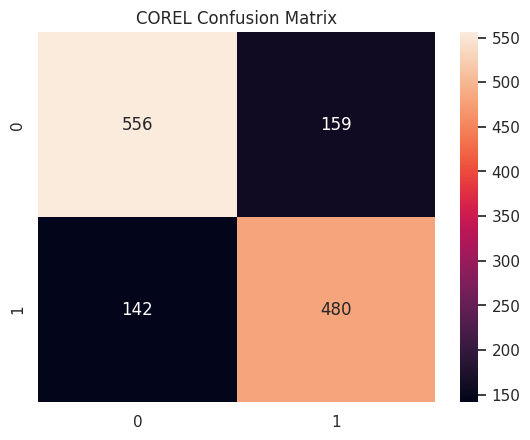

In [ ]:
cm  = confusion_matrix(yy_test, yy)
sns.heatmap(cm, annot = True, fmt = '');
plt.title('COREL Confusion Matrix')

In [ ]:
print(c.rl())

RULELIST:
if [not feature9 && not feature10 && not feature16]:
  prediction = False
else 
  prediction = True


# **Decision Tree Model**

In [ ]:
temp_data = temp_data.fillna(0) # any NaN value is substitued by a 0

In [ ]:
from pandas.core.common import temp_setattr
# X and y
X = temp_data.iloc[:,0:17]
y = temp_data.iloc[:,17].values
X.head()


,unknown-smoking,formerly smoked,never smoked,smokes,Govt job,Never worked,Private job,Self-employed,children,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,26.00000,0,0,0,1,59.670000,24.500000
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,34.00000,0,0,0,1,60.360000,24.100000
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,2.00000,0,0,0,1,125.030000,19.800000
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,74.93516,0,0,1,0,64.166503,28.993051
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,24.00000,0,0,0,1,65.440000,23.600000


In [ ]:
X = X.drop("unknown-smoking", axis = 1)
X = X.drop("children", axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 100)

In [ ]:
# Feature Scaling
# to standardize the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train) # fit_transform, because it's learning the mean and st. deviation
X_test = sc.transform(X_test) # when you are testing the data, you want it to funtion with the same mean, SD. Do not want to compute new ones

In [ ]:
# create Decision tree
clf = DecisionTreeClassifier(max_depth=8)
# The value 8 was determined by experimentation. Beyond 8, the accuracy started decreasing

In [ ]:
# Train Decision Tree classifier
clf = clf.fit(X_train,y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
# Model accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8264771877337322


In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       715
           1       0.80      0.84      0.82       622

    accuracy                           0.83      1337
   macro avg       0.83      0.83      0.83      1337
weighted avg       0.83      0.83      0.83      1337



In [ ]:
!pip install six

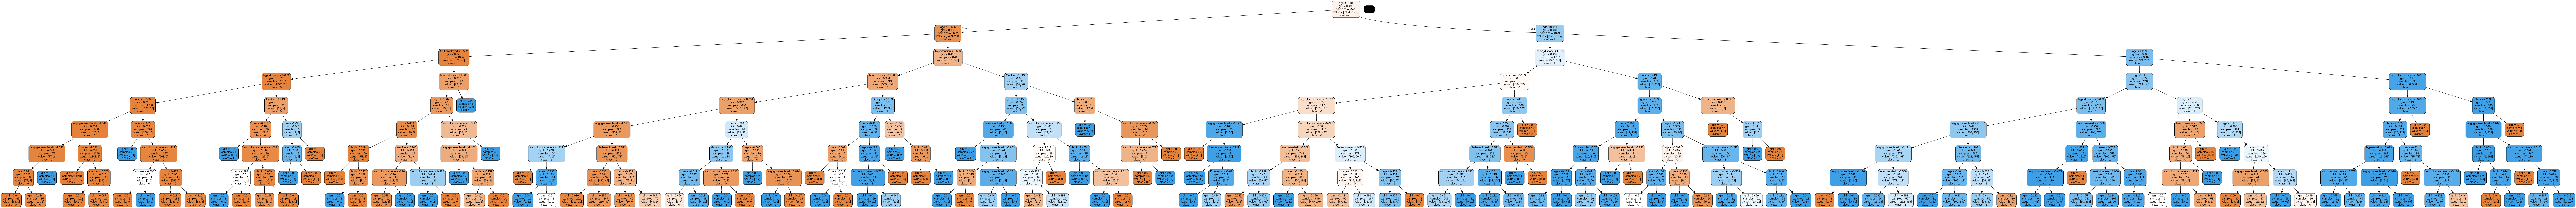

In [ ]:

feature_cols = ["formerly smoked","never smoked","smokes", "Govt job" , "Never worked", "Private job" ,"Self-employed	", "gender",	"age",	"hypertension",	"heart_disease",	"ever_married",	"Residence_type",	"avg_glucose_level",	"bmi"]
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('DecTree-Stroke.png')
Image(graph.create_png())

Accuracy: 0.8264771877337322


Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

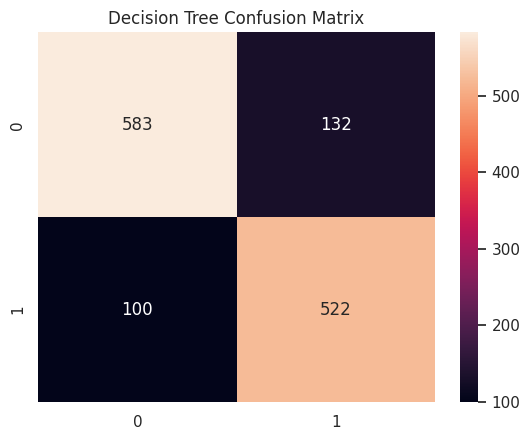

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
# Confusion Matrix
cm  = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = '');
plt.title('Decision Tree Confusion Matrix')

In [ ]:
model_fi = permutation_importance(clf, X_train, y_train)
model_fi['importances_mean']

array([0.000317  , 0.00055475, 0.00071325, 0.00565315, 0.        ,
       0.        , 0.00824198, 0.00253599, 0.25864483, 0.05428609,
       0.01981244, 0.0122573 , 0.        , 0.03288865, 0.0168802 ])

In [ ]:

start_time = time.time()
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_cols)

Elapsed time to compute the importances: 3.502 seconds


<ipython-input-77-2e3807852b03>:5: UserWarning: Glyph 9 (	) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


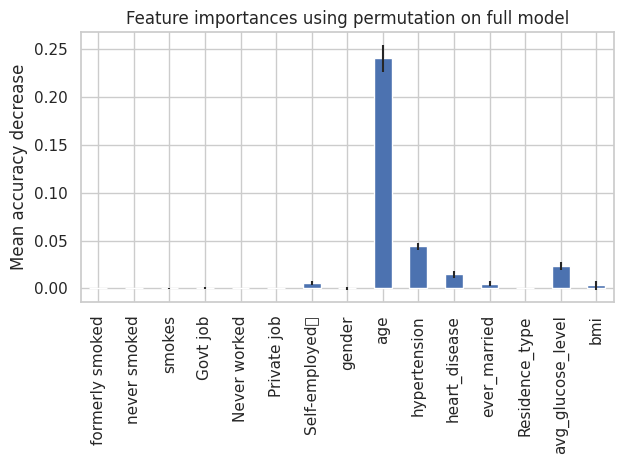

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
tree_rules = export_text(clf,
                        feature_names = feature_cols)
#print the result
print(tree_rules)

|--- age <= -0.18
|   |--- age <= -0.64
|   |   |--- Self-employed	 <= 0.52
|   |   |   |--- hypertension <= 0.69
|   |   |   |   |--- age <= -0.91
|   |   |   |   |   |--- avg_glucose_level <= -1.04
|   |   |   |   |   |   |--- avg_glucose_level <= -1.04
|   |   |   |   |   |   |   |--- bmi <= 0.14
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- bmi >  0.14
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- avg_glucose_level >  -1.04
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- avg_glucose_level >  -1.04
|   |   |   |   |   |   |--- age <= -1.03
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- age >  -1.03
|   |   |   |   |   |   |   |--- smokes <= 0.71
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- smokes >  0.71
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  -0.91
|   |   |   |   |   |--- age <= -0.88
|   |   |   |   |   |   |-